# Nepal earthquake

Author: Manuel Berea Arellano

## Chapter 0: Introduction

[Drivendata] competition: 

Richter's Predictor: Modeling Earthquake Damage  https://www.drivendata.org/competitions/57/nepal-earthquake/page/134/

### Libraries

In [1]:
#        DATA
# ==================== #

import pandas as pd
import numpy as np
import random
import math


#      PLOTING
# ============================== #

from PIL import Image
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set_theme(style="white")

#      CLUSTERING
# ============================== #
from sklearn.cluster import KMeans


#      PRE PROCESSING
# ============================== #
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

#      METRICS
# ============================== #
from sklearn.metrics import f1_score   # average='micro'
from sklearn.model_selection import cross_val_score

#      MODEL SELECTION
# ============================== #
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ParameterGrid

#      CLASIFICATORS
# ============================== #
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.svm import SVC


#      OTHERS
# ============================== #
from sklearn.inspection import permutation_importance
import multiprocessing

#      WARNINGS
# ============================== #
import warnings
warnings.filterwarnings("ignore")
import dill

In [ ]:
dill.dump_session('notebook_env.db')
#dill.load_session('notebook_env.db')

### Functions

In [2]:
def boxplots_algorithms(results, names):
    """ 
    For plot the results
    
    Para plotear los resultados 
    Input
    --------
    results (Pandas DF): Results of training models
    names: Names of the models

    Output
    --------
    Image in the notebook
    """
    
    plt.figure(figsize=(8,8))
    plt.boxplot(results)
    plt.xticks(range(1,len(names)+1), names)
    plt.show()

In [5]:
def img_reshape(img):
    """
    For show a image.
    Para mostrar una imagen.

    Input
    --------
    img (String): path image

    Output
    --------
    Image in the notebook

    """
    img = Image.open('./images/'+img).convert('RGB')
    img = img.resize((300,500))
    img = np.asarray(img)
    return img

def img_reshape_more(img):
    """
    For show a image.
    Para mostrar una imagen.

    Input
    --------
    img (String): path image

    Output
    --------
    Image in the notebook

    """
    img = Image.open('./images/'+img).convert('RGB')
    img = img.resize((1000,500))
    img = np.asarray(img)
    return img


In [4]:
def probabilities(df, test, n): 
    """
    Calculate probabilities for distinc geo level and target groups.
    Calcular las probabilidades para los distintos geo level y grupos de la target.

    Input
    --------
    df (DataFrame pandas)
    n (Int): values 1,2,3 for distinct geo level

    Output
    --------
    Dataframe with probabilities new columns
    
    """
    column = [f"geo_level_{n}_id"]
    nom1 = [f"prob1_geo{n}"]
    nom2 = [f"prob2_geo{n}"]
    nom3 = [f"prob3_geo{n}"]
    #This will save the probabilities in one column for each in df and dfOut
    damage1 = dict()
    damage2 = dict()
    damage3 = dict()

    for i, j in df[column].value_counts().iteritems():
        n1 = len(df[df.damage_grade == 1][df[column[0]] == i])
        n2 = len(df[df.damage_grade == 2][df[column[0]] == i])
        n3 = len(df[df.damage_grade == 3][df[column[0]] == i])

        damage1[i[0]] = n1/j
        damage2[i[0]] = n2/j
        damage3[i[0]] = n3/j

    list1 = []
    list2 = []
    list3 = []

    for i in df[column[0]]:
        list1.append(damage1.get(i))
        list2.append(damage2.get(i))
        list3.append(damage3.get(i))

    df[nom1[0]] = list1
    df[nom2[0]] = list2
    df[nom3[0]] = list3

    list1 = []
    list2 = []
    list3 = []

    for i in test[column[0]]:
        list1.append(damage1.get(i))
        list2.append(damage2.get(i))
        list3.append(damage3.get(i))

    test[nom1[0]] = list1
    test[nom2[0]] = list2
    test[nom3[0]] = list3
    
    return df , test

### Definitions

#### Cross Validation

A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:

A model is trained using  of the folds as training data;

the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.


#### Random Forest Classifier

Random forests or random decision forests are an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. 

Extratree classifier is a type of Random forest Classifier, the diference is the randomness goes one step further in the war splits are computed. 

#### F1 Score

To measure the performance of our algorithms, we'll use the F1 score which balances the precision and recall of a classifier. Traditionally, the F1 score is used to evaluate performance on a binary classifier, but since we have three possible labels we will use a variant called the micro averaged F1 score. 

$$ F_{micro} = \frac{ 2 \cdot P_{micro} \cdot R_{micro} }{P_{micro} + R_{micro}} $$

where 
$$ P_{micro} = \frac{\sum TP_k}{\sum (TP_k + FP_k)}, \ with \ k=1,2,3 $$
and
$$ R_{micro} = \frac{\sum TP_k}{\sum (TP_k + FN_k)}, \ with \ k=1,2,3 $$

$TP$ is true positive, $FP$ is False positive, $FN$ is False negative.

In python, you can use f_score with average ='micro'

#### Out-of-bag error

Out-of-bag (OOB) error, also called out-of-bag estimate, is a method of measuring the prediction error of random forests, boosted decision trees, and other machine learning models utilizing bootstrap aggregating (bagging). Bagging uses subsampling with replacement to create training samples for the model to learn from. OOB error is the mean prediction error on each training sample xi, using only the trees that did not have xi in their bootstrap sample.


## Chapter 1: Data Exploration

### First steps

The dataset mainly consists of information on the buildings' structure and their legal ownership. Each row in the dataset represents a specific building in the region that was hit by Gorkha earthquake.

*----*


El conjunto de datos principalmente consiste en la información estuctural de los datos y su propietario legal. Cada fila del conjunto de datos representa un edificio concreto en la region donde tuvo lugar el terremoto Gorkha.

In [ ]:
train = pd.read_csv("../data/train_values.csv")
trainTar = pd.read_csv("../data/train_labels.csv")

test = pd.read_csv("../data/test_values.csv")

We merge on one dataframe because it'll permit a better analysis. For feature engineering, we'll merge test to.

*----*

Unimos en un solo dataframe ya que nos permite un mejor analisis de la target. Para las distintas transformaciones también tendremos que unir el test.

In [ ]:
df = train.merge(trainTar , on= "building_id" , how= "left")
df.head(10)

In [ ]:
print("We have {} rows and {} columns \n  -Categorical: 8 \n  -Binary: 22 \n  -Integer: 6 ".format(len(df) , len(df.columns)))
print("- - - - - - - - - - - - - - - - - - - -")
print("Tenemos {} filas y {} columns \n  -Categoricas: 8 \n  -Binarias: 22 \n  -Enetero: 6 ".format(len(df) , len(df.columns)))

In [ ]:
print("There are {} rows duplicated".format(len(df) - df.duplicated().value_counts().values[0]))
print("- - - - - - - - - - - - - - - - - - - -")
print("Hay {} filas duplicadas".format(len(df) - df.duplicated().value_counts().values[0]))

In [ ]:
print("There are {} nan values".format(df.isna().sum().sum()))
print("- - - - - - - - - - - - - - - - - - - -")
print("Hay {} valores nulos".format(df.isna().sum().sum()))

### Outliers

There are not nan values, but we should see if there are wrong values

*-----*

No hay valores nulos, pero deberíamos mirar si hay errores en algún valor

In [ ]:
print("We select only the int columns")
print("- - - - - - - - - - - - - - - - - - - -")
print("Seleccionamos solo las columnas con dato entero")
df[["count_floors_pre_eq", "age" , "area_percentage" , "height_percentage", "count_families"]].describe()

We can see that there are 0 and 995 value for age column, this is a error value. 0 is it posible but 995 is strange.

*-----*

Vemos como hay valor 0 y 995 en la columna edad, eso es un valor erroneo. 0 es posible, pero 995 es un valor extraño.

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data = df, y ="age" , x="damage_grade")
plt.show()

With boxplot we see that very well. If we won't use robust scaler, we should drop outliers. 

*-----*

Con el boxplot lo podemos ver muy bien. Si no vamos a usar robust scaler, debemos borrar los outliers.

In [ ]:
sns.catplot(data = df, x ="age" , kind= "count" ,  aspect=4.5)

In [ ]:
print(f"There are {len(df[df['age']==995])} values with value 995, i.e {round( 100*len(df[df['age']==995]) / len(df) ,2)} % of total, these probably are unknown values.")
print("- - - - - - - - - - - - - - - - - - - -")
print(f"Hay {len(df[df['age']==995])} valores con 995, i.e {round( 100*len(df[df['age']==995]) / len(df) ,2)} % the total, son probablemente valores desconocidos.")

Here we can see the distribution:

*-----*

Aquí podemos ver la distribución:

In [ ]:
print(df[df['age']==995].groupby(['damage_grade']).count()['building_id'])

We are going to drop outliers, but in other hand we analize the age in groups and we'll see what is better.
It seems that would nice make groups with the age, because there are a lot of outliers, and we can make groups to solve this problem.

We'll do this in the next chapter.

*----*

Vamos a borrar los outliers, pero por otro lado vamos a analizar la edad en grupos y veremos cual es mejor.
Parece optimo hacer grupos de edad de los edificiones, porque hay muchos outliers y podemos hacer grupos para resolver este problema.

Heremos esto en el proximo capítulo.

In [ ]:
Q_1 = df.describe().loc['25%'].loc['age']
Q_3 = df.describe().loc['75%'].loc['age']
IQR = Q_3 - Q_1
df['outliers'] = df['age'].apply( lambda x : 1 if ((x < (Q_1 - 1.5*IQR) ) or ( (Q_3 + 1.5 * IQR) < x ) ) else 0 )
print(f"There are {df['outliers'].sum()} outliers, i.e {round( 100*df['outliers'].sum() / len(df) , 2 )} % of total, we are going to drop it")
print("- - - - - - - - - - - - - - - - - - - -")
print(f"Hay {df['outliers'].sum()} outliers, es un {round( 100*df['outliers'].sum() / len(df) , 2 )} % del total, vamos a sacarlos del estudio")
dfOut = df[df['outliers'] == 0]

In [ ]:
plt.figure(figsize=(15,10))
sns.boxplot(data = dfOut, y ="age" , x="damage_grade")
plt.show()

In [ ]:
sns.catplot(data = dfOut, x ="age" , kind= "count" ,  aspect=4.5)

In [ ]:
dfOut[["count_floors_pre_eq", "age" , "area_percentage" , "height_percentage", "count_families"]].describe()

Now we are going to see "area_percentage" and "height_percentage", because it seems like there are outliers too.

*-----*

Vamos a ver la columna "area_percentage" y "height_percentage", porque parece que también tiene outliers.

In [ ]:
print(dfOut[["area_percentage", "height_percentage"]].describe())

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
fig.suptitle("Area and Height percentage boxplot")
#-----#
ax1.set_title("Area percentage")
ax1.boxplot(dfOut[["area_percentage"]])
#-----#
ax2.set_title("Hight percentage")
ax2.boxplot(dfOut[["height_percentage"]])
plt.show()

For these columns, probably the best idea is use a robust scaler, because 100% value is posible and don't seems an unknown value.

*-----*

Para estas columns, probablemente la mejor idea es usar un robust scaler, porque el valor 100% es posible y no parece un valor desconocido.

Before outliers analysis we have:

*------*

Después del analisis de outliers tenemos:

In [ ]:
print(f"We drop outlierns, now we have {round (100 - len(dfOut)*100 / len(df) ,2)} % less rows than the initial dataframe.")
print("- - - - - - - - - - - - - - - - - - - -")
print(f"Hemos borrado outliers, ahora tenemos un {round (100 - len(dfOut)*100 / len(df) ,2)} % menos filas que el dataframe original.")

### Numeric correlation

In [ ]:
numeric = ["count_floors_pre_eq", "age" , "area_percentage" , "height_percentage", "count_families"]

In [ ]:
corrTot = df[numeric].corr()
corrOut = dfOut[numeric].corr()

Here we see the diferences between corrTot and corrOut

*-----*

Aqui vemos las diferencias entra ambas correlaciones

In [ ]:
abs(corrTot-corrOut)

We are going to analize only the corrTot, because the diferences are minimun.

*------*

Vamos a analizar la correlacion solo de corrTot, porque las diferencias son mínimas.

In [ ]:
#CORPLOT
plt.figure(figsize=(8, 9))
maskTot = np.triu(np.ones_like(corrTot, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrTot, mask=maskTot, cmap=cmap, vmax=.3, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .8} )
plt.show()

The highest correlation is between number floors pre earthquake and the porcent height. But 0.77 is not enought for drop the column.

*------*

La correlación más alta es entre numero de plantas antes del terremoto y el porcentaje de altura. Pero 0.77 no es suficiente para borrar la columna.

## Chapter 2: Featuring Engineering and Selection

### Categorical columns

In [ ]:
categorical = ['land_surface_condition','foundation_type','roof_type','ground_floor_type','other_floor_type','position','plan_configuration','legal_ownership_status']

##### Land surface condition

Surface condition of the land where the building was built. 

*-----*

Estado de la superficio del terreno donde se contruyó el edificio.


Possible values: n, o, t.

In [ ]:
print(round(df.groupby(categorical[0]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[0] , bins=len(set(df[categorical[0]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[0], bins=len(set(df[categorical[0]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[0])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[0] , kind= 'count', hue = 'damage_grade')
plt.show()

With this to analisis, we are going to group the o and n values in one.

*-----*

Con este analisis, vamos a agrupar los valores o y n en solo uno.


In [ ]:
df[categorical[0]] = df[categorical[0]].apply(lambda x: 1 if x == 't' else 0)
dfOut[categorical[0]] = dfOut[categorical[0]].apply(lambda x: 1 if x == 't' else 0)

test[categorical[0]] = test[categorical[0]].apply(lambda x: 1 if x == 't' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[0] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Foundation type

Type of foundation used while building. 

*----*

Tipo de financiacion usada cuando se contruyó el edificio.

Possible values: h, i, r, u, w.



In [ ]:
print(round(df.groupby(categorical[1]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[1] , bins=len(set(df[categorical[1]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[1], bins=len(set(df[categorical[1]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[1])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[1] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[1]] = df[categorical[1]].apply(lambda x : 1 if x == 'r' else 0)
dfOut[categorical[1]] = dfOut[categorical[1]].apply(lambda x : 1 if x == 'r' else 0)

test[categorical[1]] = test[categorical[1]].apply(lambda x : 1 if x == 'r' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[1] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Roof type

Type of roof used while building. 

*-----*

Tipo de tejado empleado al construir el edificio

Possible values: n, q, x.

In [ ]:
print(round(df.groupby(categorical[2]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[2] , bins=len(set(df[categorical[2]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[2], bins=len(set(df[categorical[2]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[2])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[2] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[2]] = df[categorical[2]].apply(lambda x : 1 if x == 'q' else 0)
dfOut[categorical[2]] = dfOut[categorical[2]].apply(lambda x : 1 if x == 'q' else 0)

test[categorical[2]] = test[categorical[2]].apply(lambda x : 1 if x == 'q' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[2] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Ground floor type

Type of the ground floor. 

*-----*

Tipo de suelo.

Possible values: f, m, v, x, z.

In [ ]:
print(round(df.groupby(categorical[3]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[3] , bins=len(set(df[categorical[3]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[3], bins=len(set(df[categorical[3]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[3])
plt.show()

In [ ]:
df[categorical[3]] = df[categorical[3]].apply(lambda x : 'other' if x == 'z' else 'other' if x == 'm' else x)
dfOut[categorical[3]] = dfOut[categorical[3]].apply(lambda x : 'other' if x == 'z' else 'other' if x == 'm' else x)

In [ ]:
print(round(df.groupby(categorical[3]).count()['building_id'] *100 / len(df) ,2 ) )
sns.catplot(data= df , x = categorical[3] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[3]] = df[categorical[3]].apply(lambda x : 1 if x == 'f' else 0)
dfOut[categorical[3]] = dfOut[categorical[3]].apply(lambda x : 1 if x == 'f' else 0)

test[categorical[3]] = test[categorical[3]].apply(lambda x : 1 if x == 'f' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[3] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Other floor type

 Type of constructions used in higher than the ground floors (except of roof). 
 
 *-----*

 Tipo de materiales usados en plantas superiores distintas a la baja y techo.
 
 Possible values: j, q, s, x.

In [ ]:
print(round(df.groupby(categorical[4]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[4] , bins=len(set(df[categorical[4]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[4], bins=len(set(df[categorical[4]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[4])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[4] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[4]] = df[categorical[4]].apply(lambda x : 'j' if x == 's' else x)
dfOut[categorical[4]] = dfOut[categorical[4]].apply(lambda x : 'j' if x == 's' else x)

test[categorical[4]] = test[categorical[4]].apply(lambda x : 'j' if x == 's' else x)

In [ ]:
df[categorical[4]] = df[categorical[4]].apply(lambda x : 2 if x == 'q' else 1 if x == 'x' else  0)
dfOut[categorical[4]] = dfOut[categorical[4]].apply(lambda x : 2 if x == 'q' else 1 if x == 'x' else  0)

test[categorical[4]] = test[categorical[4]].apply(lambda x : 2 if x == 'q' else 1 if x == 'x' else  0)

In [ ]:
sns.catplot(data= df , x = categorical[4] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Position

Position of the building. 

*-----*

Posición del edificio.

Possible values: j, o, s, t.

In [ ]:
print(round(df.groupby(categorical[5]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[5] , bins=len(set(df[categorical[5]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[5], bins=len(set(df[categorical[5]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[5])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[5] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[5]] = df[categorical[5]].apply(lambda x : 1 if x == 's' else 0)
dfOut[categorical[5]] = dfOut[categorical[5]].apply(lambda x : 1 if x == 's' else 0)

test[categorical[5]] = test[categorical[5]].apply(lambda x : 1 if x == 's' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[5] , kind= 'count', hue = 'damage_grade')
plt.show()

##### Plan configuration

Building plan configuration. 

*-----*

Configuración del plano del edificio.

Possible values: a, c, d, f, m, n, o, q, s, u.

In [ ]:
print(round(df.groupby(categorical[6]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[6] , bins=len(set(df[categorical[6]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[6], bins=len(set(df[categorical[6]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[6])
plt.show()

In [ ]:
sns.catplot(data= df , x = categorical[6] , kind= 'count', hue = 'damage_grade')
plt.show()

In [ ]:
df[categorical[6]] = df[categorical[6]].apply(lambda x : 1 if x == 'd' else 0)
dfOut[categorical[6]] = dfOut[categorical[6]].apply(lambda x : 1 if x == 'd' else 0)

test[categorical[6]] = test[categorical[6]].apply(lambda x : 1 if x == 'd' else 0)

In [ ]:
sns.catplot(data= df , x = categorical[6] , kind= 'count', hue = 'damage_grade')
plt.show()

This column is not well clustered, we are going to drop it

*----*

Esta columna no está bien repartida, vamos a eliminarla.

In [ ]:
df = df.drop(categorical[6], axis = 1)
dfOut = dfOut.drop(categorical[6], axis = 1)

test = test.drop(categorical[6], axis = 1)

##### Legal ownership status

Legal ownership status of the land where building was built. 

*-----*

Situación de la propiedad legal del terreno donde se construyó el edificio. 


Possible values: a, r, v, w.

In [ ]:
print(round(df.groupby(categorical[7]).count()['building_id'] *100 / len(df) ,2 ) )
fig , (ax1,ax2) = plt.subplots(1,2, figsize=(15,6))
ax1.hist(data = df , x = categorical[7] , bins=len(set(df[categorical[7]])))
ax1.set_title("Dataframe total")
ax2.hist(data = dfOut , x = categorical[7], bins=len(set(df[categorical[7]])))
ax2.set_title("Dataframe without outliers")
plt.suptitle(categorical[7])
plt.show()

In [ ]:
df = df.drop(categorical[7], axis = 1)
dfOut = dfOut.drop(categorical[7], axis = 1)

test = test.drop(categorical[7], axis = 1)

### Geo columns

Geographic region in which building exists, from largest (level 1) to most specific sub-region (level 3). 


*-----*


Region geográfica en donde hay edificios, del más grande (level 1) al mas especifico, sub region (level 3).

Possible values: level 1: 0-30, level 2: 0-1427, level 3: 0-12567.

In [ ]:
geos = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id']

In [ ]:
for i in [0,1,2]:
    print("\n- - - - - - - ")
    with pd.option_context('display.max_rows',10):
        print(df[geos[i]].value_counts())

We'll calculate the probability of belonging to one target group or another based on the geo level columns. This will help us to cluster the diferent positions.

*-------*

Vamos a calcular la probabilidad de pertenecer a un grupo de la target u otro en función de las columnas de geo level. Esto nos ayudará a relacionar las distintas posiciones y clusterizarlas.

In [ ]:
df, test = probabilities(df,test,1)
df, test = probabilities(df,test,2)
df, test = probabilities(df,test,3)

#df.to_csv("../data/trainProb.csv")
#test.to_csv("../data/testProb.csv")

In [ ]:
dfOut, testOut = probabilities(dfOut,test,1)
dfOut, testOut = probabilities(dfOut,test,2)
dfOut, testOut = probabilities(dfOut,test,3)

#dfOut.to_csv("../data/trainOutProb.csv")
#testOut.to_csv("../data/testOutProb.csv")

In [ ]:
#df = pd.read_csv("../data/trainProb.csv")
#test = pd.read_csv("../data/testProb.csv")

#dfOut = pd.read_csv("../data/trainOutProb.csv")
#testOut = pd.read_csv("../data/testOutProb.csv")

In [ ]:
probs = ['prob1_geo1','prob2_geo1', 'prob3_geo1', 'prob1_geo2', 'prob2_geo2', 'prob3_geo2','prob1_geo3', 'prob2_geo3', 'prob3_geo3']

In [ ]:
nClus = range(3, 10)
kmeans = [KMeans(n_clusters=i, random_state= 1995) for i in nClus]

score = [kmeans[i].fit(df[probs]).score(df[probs]) for i in range(len(kmeans))]

plt.plot(nClus,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

Seen the plot, I'll choose 5 clusters.

*-------*

Viendo el gráfico, voy a escoger 5 clusters.

In [ ]:
kmeans = KMeans(n_clusters = 5 , random_state = 1995 )
kmeans.fit(df[probs])

# Predicting the clusters
labels = kmeans.predict(df[probs])
labelsT = kmeans.predict(test[probs])

df['clusters'] = labels
test['clusters'] = labelsT

# *-----*

kmeans = KMeans(n_clusters = 5 , random_state = 1995 )
kmeans.fit(dfOut[probs])

# Predicting the clusters
labels = kmeans.predict(dfOut[probs])
labelsT = kmeans.predict(testOut[probs])

dfOut['clusters'] = labels
testOut['clusters'] = labelsT

In [ ]:
sns.catplot(data= df , x = "clusters" , kind="count" , hue= "damage_grade")
plt.show()

### Binary columns

Finally we need to analize the binary columns.

*-----*

Finalmente vamos a analizar las columnas de valor binario.

In [ ]:
binary = ['has_secondary_use','has_secondary_use_agriculture','has_secondary_use_gov_office','has_secondary_use_health_post',
            'has_secondary_use_hotel','has_secondary_use_industry','has_secondary_use_institution','has_secondary_use_other',
            'has_secondary_use_rental','has_secondary_use_school','has_secondary_use_use_police','has_superstructure_adobe_mud',
            'has_superstructure_bamboo','has_superstructure_cement_mortar_brick','has_superstructure_cement_mortar_stone', 
            'has_superstructure_mud_mortar_brick', 'has_superstructure_mud_mortar_stone', 'has_superstructure_other', 
            'has_superstructure_rc_engineered','has_superstructure_rc_non_engineered', 'has_superstructure_stone_flag', 'has_superstructure_timber']

In [ ]:
print("\t\t% of 1 in the columns")
print("\t- - - - - - - - - - - - - - - - - - - ")
print("\t\t% de 1 en las columnas")
round(df[binary].sum() *100 / len(df) , 2)

In [ ]:
dp = list()
for x in binary:
    if (round(df[x].sum() *100 / len(df) , 2) < 10.0) == True:
        dp.append(x)

In [ ]:
df_mod = df.drop(dp, axis=1)
dfOut_mod = dfOut.drop(dp, axis=1)
test_mod = test.drop(dp, axis=1)
testOut_mod = testOut.drop(dp, axis=1)


For the first model, we'll use:

*------*

Para el primer modelo, vamos a usar:

In [ ]:
df.head()

### Numeric

In [ ]:
numeric = ["count_floors_pre_eq", "age" , "area_percentage" , "height_percentage", "count_families"]

#### Count floors pre earthquake

Number of floors in the building before the earthquake.

*------*

Numero de plantas del edificio pre terremoto.

In [ ]:
sns.catplot(data = df , x = numeric[0] , kind= 'count', hue='damage_grade')
plt.show()

In [ ]:
df[numeric[0]] = df[numeric[0]].apply(lambda x: x if x<3 else 3)
dfOut[numeric[0]] = dfOut[numeric[0]].apply(lambda x: x if x<3 else 3)
test[numeric[0]] = test[numeric[0]].apply(lambda x: x if x<3 else 3)

In [ ]:
sns.catplot(data = df , x = numeric[0] , kind= 'count', hue='damage_grade')
plt.show()

#### Age

Age of the building in years.

*------*

Edad del edificio en años.

In [ ]:
sns.catplot(data = dfOut , x = numeric[1] , kind= 'count', hue='damage_grade', height=8)
plt.show()

In [ ]:
dfOut[numeric[1]].value_counts()

Needs robust scaler

Normalized area and height of the building footprint.

*------*

Superficie y altura normalizadas de la huella del edificio.

#### Count Families

Number of families that live in the building.

*-------*

Numero de familias que viven en el edificio.

In [ ]:
sns.catplot(data = df , x = numeric[4] , kind= 'count', hue='damage_grade')
plt.show()

In [ ]:
df[numeric[4]] = df[numeric[4]].apply(lambda x: x if x<2 else 2)
dfOut[numeric[4]] = dfOut[numeric[4]].apply(lambda x: x if x<2 else 2)
test[numeric[4]] = test[numeric[4]].apply(lambda x: x if x<2 else 2)

In [ ]:
sns.catplot(data = df , x = numeric[4] , kind= 'count', hue='damage_grade')
plt.show()

## Chapter 3: Experimentation

### First models: Evaluating and comparing models

In [6]:
target = 'damage_grade'
numeric = [ "age" ,'prob1_geo1','prob1_geo2','prob1_geo3','prob2_geo1','prob2_geo2','prob2_geo3','prob3_geo1','prob3_geo2','prob3_geo3']
categorical = ['clusters','roof_type',"area_percentage" , "height_percentage","count_floors_pre_eq", "count_families",'foundation_type','ground_floor_type','has_secondary_use','has_superstructure_mud_mortar_stone','has_superstructure_timber','land_surface_condition','other_floor_type','position']

In [ ]:
set(df_mod.columns) - set([target]) - set(numeric) - set(categorical)

In [ ]:
escaler = RobustScaler().fit(df[numeric])
escalerOut = RobustScaler().fit(dfOut[numeric])

In [ ]:
df[numeric] = escaler.transform(df[numeric])
test[numeric] = escaler.transform(test[numeric])

dfOut[numeric] = escalerOut.transform(dfOut[numeric])
testOut[numeric] = escalerOut.transform(testOut[numeric])

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns = [target,'outliers']), df[target],random_state = 1995)
X_trainO, X_testO, y_trainO, y_testO = train_test_split(dfOut.drop(columns = [target,'outliers']), dfOut[target],random_state = 1995)

#### Compare distinct models

We are going to compare the distinct type of classifiers for select the better options and for each selected model do hyperparameter tunning.

*-----*

Vamos a comparar los distintos tipos de clasificadores para seleccionar la mejor option y para cada uno de estos hacer el tuneado de los hiperparámetros.

In [9]:
seed = 1995
models = []
models.append(('LR'     , LogisticRegression(random_state=seed)))
models.append(('LDA'    , LinearDiscriminantAnalysis()))
models.append(('KNN'    , KNeighborsClassifier()))
models.append(('DTC'    , DecisionTreeClassifier(random_state=seed)))
models.append(('NB'     , GaussianNB()))
models.append(('RFC'    , RandomForestClassifier(random_state=seed)))
models.append(('EXT'    , ExtraTreesClassifier(random_state = seed)))
models.append(('LGBM'   , LGBMClassifier(random_state=seed)))

LR: 0.566338 (0.000011)
LDA: 0.744959 (0.001836)
KNN: 0.493632 (0.001427)
DTC: 0.666405 (0.002307)
NB: 0.566161 (0.000079)
RFC: 0.742175 (0.001967)
EXT: 0.729508 (0.002428)
LGBM: 0.759905 (0.001677)


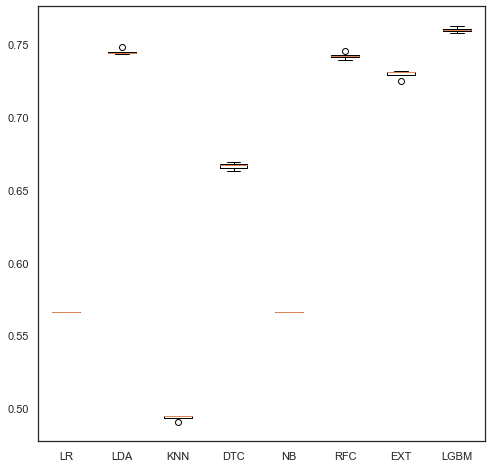

In [10]:
results = []
names = []
metric = 'f1_micro'

for name, model in models:

    cv_results = cross_val_score(model, X_trainO, y_trainO, cv =5, scoring = metric)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

LDA: 0.744959 (0.001836)
RFC: 0.742175 (0.001967)
EXT: 0.729508 (0.002428)
LGBM: 0.759905 (0.001677)


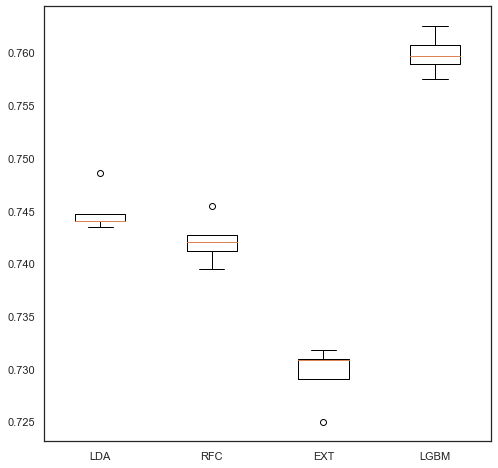

In [12]:
seed = 1995
models = []
models.append(('LDA'    , LinearDiscriminantAnalysis()))
models.append(('RFC'    , RandomForestClassifier(random_state=seed)))
models.append(('EXT'    , ExtraTreesClassifier(random_state = seed)))
models.append(('LGBM'   , LGBMClassifier(random_state=seed)))

results = []
names = []
metric = 'f1_micro'

for name, model in models:

    cv_results = cross_val_score(model, X_trainO, y_trainO, cv =5, scoring = metric)

    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

    results.append(cv_results)
    names.append(name)
    
boxplots_algorithms(results, names)

#### Model 1: Linear discriminant analysis

Linear discriminant analysis is the most easy way to explain the models. We can get the coefs and with this coefs explain the predictions.

*-----*

Analisis discriminantes es la forma más fácil de explicar modelos. Ya que nos devuelve los distintos coeficientes que nos ayudan a explicar las prediccioes. 

In [16]:
param = {
    'solver' : ['svd', 'lsqr', 'eigen'] 
}

CVLRmodel = LinearDiscriminantAnalysis()

gridLDA = GridSearchCV( estimator = CVLRmodel,
                        param_grid = param,
                        scoring = 'f1_micro',
                        n_jobs = -1,
                        refit = True,
                        cv = 5,
                        verbose = 1,
                        return_train_score = True)

gridLDA.fit(X_trainO,y_trainO)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


GridSearchCV(cv=5, estimator=LinearDiscriminantAnalysis(), n_jobs=-1,
             param_grid={'solver': ['svd', 'lsqr', 'eigen']},
             return_train_score=True, scoring='f1_micro', verbose=1)

In [17]:
prediccionesLDA = gridLDA.predict(X = X_testO)

f1score0 = f1_score(
        y_true  = y_testO,
        y_pred  = prediccionesLDA,
        average = 'micro'
    )

print(f"El f1 score de test es: {round(f1score0,3)} con outliers")

In [21]:
test_copy = testOut.copy()

prediccionesLDA = gridLDA.predict(test_copy)
test_copy['damage_grade'] = prediccionesLDA
test_copy[['building_id','damage_grade']].to_csv("../predictions/predLDAmodel1.csv", index = False)

I took 0.7203 score in drivenData platform. Now we have try with the other models.

*----*

Obtuve 0.7203 de score en la plataforma de drivenData. Ahora vamos a probar con otros modelos.

#### Model 2: RandomForest

In [13]:
modelo = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            max_depth    = 10,
            max_features = 'auto',
            n_jobs       = -1,
            random_state = 1995)


modeloOut = RandomForestClassifier(
            n_estimators = 150,
            criterion    = 'gini',
            max_depth    = 10,
            max_features = 'auto',
            n_jobs       = -1,
            random_state = 1995)

In [14]:
modelo.fit(X_train, y_train) , modeloOut.fit(X_trainO, y_trainO)

(RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1,
                        random_state=1995),
 RandomForestClassifier(max_depth=10, n_estimators=150, n_jobs=-1,
                        random_state=1995))

In [22]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modelo.predict(X = X_test)

f1score1 = f1_score(
        y_true  = y_test,
        y_pred  = predicciones,
        average = 'micro'
       )
print(f"El f1 score de test es: {round(f1score1,3)} con outliers")

El f1 score de test es: 0.754 con outliers


In [ ]:
test1 = test.copy()
testOut1 = testOut.copy()


predicciones = modelo.predict(test1)
test['damage_grade'] = predicciones
test[['building_id','damage_grade']].to_csv("../predictions/predETCmodel1.csv", index = False)


prediccionesOut = modeloOut.predict(testOut1)
testOut['damage_grade'] = prediccionesOut
testOut[['building_id','damage_grade']].to_csv("../predictions/predOutETCmodel1.csv", index = False)

Now we have a first point to improve. The next steps are:
    
    - Tunning the model
  
    - Compare with other algorithms
  
    - Improve our featuring engineering, for exmple, changing the clustering.
  

Model with outliers


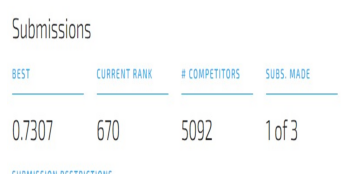

In [23]:
print("Model with outliers")
pred_model1 = img_reshape_more('/prediccions/one.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

Model without outliers


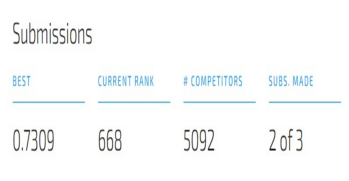

In [24]:
print("Model without outliers")
pred_model1 = img_reshape_more('/prediccions/oneOut.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

##### Hyperparameter tunning: Num estimators

We are going to use a loop for training the diferent models with each n_estimador value and take train error and Out-of Bag value. It'll permit us choose the best parameter option for our dataframe.
It's important choose the less number of trees with the best score, more trees wont improve our power prediction but it will make us don't have the best performance.

*------*

Vamos a utilizar un bucle para entrenar los diferentes moderlos con cada uno de los valores de los estimadores y cogeremos el error y el valor Out.of-bag. Esto nos va a permitir elegir la mejor opcion de parámetros para nuestro conjunto de datos. Es importante elegir el menor número de árboles con el mayor score, más arboles no implica mayor poder predictivo, pero si que hará empeorar nuestro performance.

In [ ]:
train_scores = []
oob_scores   = []

estimator_range = range(1, 200, 25)

# Loop for training models with each n_estimator value and take
# train error and Out-of-Bag value.
for n_estimators in estimator_range:
    model = ExtraTreesClassifier(
                n_estimators = n_estimators,
                criterion    = 'gini',
                max_depth    = 10,
                max_features = 'auto',
                bootstrap    = True,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 1995
             )

    model.fit(X_train, y_train)
    train_scores.append(model.score(X_train, y_train))
    oob_scores.append(model.oob_score_)
    
# Graph for analize the error
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, oob_scores, label="out-of-bag scores")
ax.plot(estimator_range[np.argmax(oob_scores)], max(oob_scores),
        marker='o', color = "red", label="max score")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution out-of-bag-error vs num estimators")
plt.legend();
print(f"Best value of n_estimators: {estimator_range[np.argmax(oob_scores)]}")

Now we will use cross validation with f1 score. 

*-----*

Ahora vamos a utilizar cross validation con la métrica f1.

In [ ]:
# CV validation
# ==============================================================================
estimator_range = range(1, 100, 20)
cv_scores = []
for n_estimators in estimator_range:
    
    modelo = ExtraTreesClassifier(
                n_estimators = n_estimators,
                criterion    = 'gini',
                max_depth    = 10,
                max_features = 'auto',
                bootstrap    = True,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 1995
             )
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'f1_micro',
                cv        = 5
             )   
    cv_scores.append(scores.mean())

print(f"Best value of n_estimators: {estimator_range[np.argmax(cv_scores)]}")

We should take around 50 and 60 trees.

*-----*

Debemos coger entre 50 y 60 árboles.

##### Hyperparameter tunning: Max features

In [ ]:
# CV validation
# ==============================================================================
max_features_range = range(1, X_train.shape[1] + 1, 1)
cv_scores = []
for max_features in max_features_range:
    
    modelo = ExtraTreesClassifier(
                n_estimators = 55,
                criterion    = 'gini',
                max_depth    = 10,
                max_features = max_features,
                bootstrap    = True,
                oob_score    = True,
                n_jobs       = -1,
                random_state = 1995
             )
    scores = cross_val_score(
                estimator = modelo,
                X         = X_train,
                y         = y_train,
                scoring   = 'f1_micro',
                cv        = 5
             )   
    cv_scores.append(scores.mean())

    
print(f"Best value of n_estimators: {max_features_range[np.argmax(cv_scores)]}")

In [ ]:
modeloSte = ExtraTreesClassifier(
            n_estimators = 55,
            criterion    = 'gini',
            max_depth    = 10,
            max_features = 46,
            n_jobs       = -1,
            random_state = 1995)


modeloSteOut = ExtraTreesClassifier(
            n_estimators = 55,
            criterion    = 'gini',
            max_depth    = 10,
            max_features = 46,
            n_jobs       = -1,
            random_state = 1995)

In [ ]:
modeloSte.fit(X_train, y_train) , modeloSteOut.fit(X_trainO, y_trainO)

In [ ]:
# Error de test del modelo inicial
# ==============================================================================
predicciones = modeloSte.predict(X = X_test)

f1score1 = f1_score(
        y_true  = y_test,
        y_pred  = predicciones,
        average = 'micro'
       )
print(f"El f1 score de test es: {f1score1} con outliers")

In [ ]:
test1 = test.copy()
testOut1 = testOut.copy()

predicciones = modeloSte.predict(test1)
test['damage_grade'] = predicciones
test[['building_id','damage_grade']].to_csv("../predictions/predETCmodel2.csv", index = False)


prediccionesOut = modeloSteOut.predict(testOut1)
testOut['damage_grade'] = prediccionesOut
testOut[['building_id','damage_grade']].to_csv("../predictions/predOutETCmodel2.csv", index = False)

In [ ]:
print("Model without outliers")
pred_model1 = img_reshape_more('/prediccions/twoOut.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

##### Hyperparameter tunning: Grid search

In [ ]:
# Hyperparameter Grid
# ==============================================================================
param_grid = {'n_estimators': [50,55,60],
              'max_features': [46,None],
              'max_depth'   : [None, 3,5,10],
              'criterion'   : ['gini']
             }

# Grid serach CV 
# ==============================================================================
gridRF = GridSearchCV(
        estimator  = ExtraTreesClassifier(random_state = 1995),
        param_grid = param_grid,
        scoring    = 'f1_micro',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1995), 
        refit      = True,
        verbose    = 1,
        return_train_score = True
       )

gridRF.fit(X = X_trainO, y = y_trainO)

In [ ]:
grid.best_estimator_

In [ ]:
modeloHyperOut = ExtraTreesClassifier(
            n_estimators = 50,
            criterion    = 'gini',
            max_depth    = 10,
            max_features = 46,
            n_jobs       = -1,
            random_state = 1995)

In [ ]:
modeloHyperOut.fit(X_trainO,y_trainO)

In [ ]:
testOut2 = testOut.drop("damage_grade",axis=1).copy()

prediccionesOut = modeloHyperOut.predict(testOut2)
testOut2['damage_grade'] = prediccionesOut
testOut2[['building_id','damage_grade']].to_csv("../predictions/predOutETCmodel3.csv", index = False)

In [ ]:
print("Model without outliers")
pred_model1 = img_reshape_more('/prediccions/threeOut.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

#### Model 3: LightGBM Classifier 

##### Num estimators

In [ ]:
train_scores = []
f1_scores   = []
estimator_range = range(25, 500, 25)
# Loop for training models with each n_estimator value and take
# train error and f1 score
for n_estimators in estimator_range:
    model = LGBMClassifier(boosting_type = 'gbdt', 
                    learning_rate=0.01, 
                    max_depth=10, 
                    n_estimators= n_estimators, 
                    n_jobs =-1, 
                    num_leaves=124, 
                    objective='multiclass',
                    random_state=1995)

    model.fit(X_trainO, y_trainO)
    train_scores.append(model.score(X_trainO, y_trainO))
    
    predicciones = model.predict(X = X_testO)

    f1score1 = f1_score(
            y_true  = y_testO,
            y_pred  = predicciones,
            average = 'micro'
        )
    f1_scores.append(f1score1)
# Graph for analize the error
fig, ax = plt.subplots(figsize=(6, 3.84))
ax.plot(estimator_range, train_scores, label="train scores")
ax.plot(estimator_range, f1_scores, label="F1 Score")
ax.plot(estimator_range[np.argmax(f1_scores)], max(f1_scores),
        marker='o', color = "red", label="max score")
ax.set_xlabel("n_estimators")
ax.set_title("Evolution F1 Score vs num estimators")
plt.legend();
print(f"Best value of n_estimators: {estimator_range[np.argmax(f1_scores)]} with f1 score: {max(f1_scores)}")

We are going to try with this num estimators.

*-----*

Vamos a probar con esta cantidad de estimadores.

In [ ]:
modeloLGBMOut = LGBMClassifier(boosting_type = 'gbdt', 
                    learning_rate=0.01, 
                    max_depth=10, 
                    n_estimators= 425, 
                    n_jobs =-1, 
                    num_leaves=124, 
                    objective='multiclass',
                    random_state=1995)

In [ ]:
modeloLGBMOut.fit(X_trainO,y_trainO)

In [ ]:
testOut3 = testOut.copy()

prediccionesOut = modeloLGBMOut.predict(testOut3)
testOut3['damage_grade'] = prediccionesOut
testOut3[['building_id','damage_grade']].to_csv("../predictions/predOutLGBMmodel1.csv", index = False)

In [ ]:
print("Model without outliers")
pred_model1 = img_reshape_more('/prediccions/threeOut.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

##### Searchgrid CV

In [ ]:
# Hyperparameter Grid
# ==============================================================================
param_grid = {'n_estimators': [400,425,450],
              'num_leaves'  : [10,35,135],
              'max_depth'   : [-1,5,10],
              'learning_rate':[0.01]
             }

# Grid serach CV 
# ==============================================================================
gridLGBM = GridSearchCV(
        estimator  = LGBMClassifier(boosting_type = 'gbdt', 
                    learning_rate=0.01, 
                    max_depth=10, 
                    n_jobs =-1,  
                    objective='multiclass',
                    random_state=1995),
        param_grid = param_grid,
        scoring    = 'f1_micro',
        cv         = RepeatedKFold(n_splits=5, n_repeats=3, random_state=1995), 
        refit      = True,
        verbose    = 0,
        return_train_score = True
       )

gridLGBM.fit(X = X_trainO, y = y_trainO)

In [ ]:
gridLGBM.best_estimator_

In [ ]:
modelLGBM =  LGBMClassifier(boosting_type = 'gbdt', 
                    learning_rate=0.01, 
                    max_depth=10, 
                    n_estimators= 450, 
                    n_jobs =-1, 
                    num_leaves=135, 
                    objective='multiclass',
                    random_state=1995)

modelLGBM.fit(X_trainO, y_trainO)

prediccionesLGBM = modelLGBM.predict(X = X_testO)

f1score1 = f1_score(
        y_true  = y_testO,
        y_pred  = prediccionesLGBM,
        average = 'micro'
    )

In [ ]:
testOut4 = testOut.copy()

prediccionesLGBM = modelLGBM.predict(testOut4)
testOut4['damage_grade'] = prediccionesLGBM
testOut4[['building_id','damage_grade']].to_csv("../predictions/predOutLGBMmodel2.csv", index = False)

LGBM hyperparameter tunning


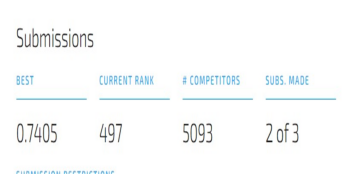

In [25]:
print("LGBM hyperparameter tunning")
pred_model1 = img_reshape_more('/prediccions/threeOutLGBMHYPER.jpg')
plt.imshow(np.asarray(pred_model1))
plt.axis('off')
plt.show()

## Chapter 4: Featuring Engineering and selection (part 2)

- log(age) --> Power tranformers (Box-Cox)
- Truco cuantiles  ---> CountMinSketch
- Cambiar numero de clusters
- Utilizar min-max scaler por dispersion

### Second models: Evaluating and comparing models

Cambiar a stratifiedkfolds, realizar variables del excel, cambiar numero de clusters a 7

## Chapter 5: Choosing best model, version management and reproducibility

## Chapter 6: Preparing for production

## Chapter 7: Deploying to production

## Chapter 8: Conclusions

# Bibliography

    Treveil, M. & the Dataiku Team. (2020). Introducing MLOps (1.a ed., Vol. 1). O’Reilly.

    Zheng, A., & Casari, A. (2018). Feature Engineering for Machine Learning: Principles and Techniques for Data Scientists. O’Reilly Media.

    Hunter, J., Dale, D., Firing, E., Droettboom, M., & The Matplotlib development team. (2002-2021). Matplotlib. Matplotlib 3.5.1 documentation. 
    https://matplotlib.org/stable/index.html

    scikit-learn: machine learning in Python — scikit-learn 1.0.2 documentation. (2021). Scikit-Learn. 
    https://scikit-learn.org/stable/


    Wikipedia contributors. (2021, 12 septiembre). Out-of-bag error. Wikipedia. https://en.wikipedia.org/wiki/Out-of-bag_error

    (2019). Richter’s Predictor: Modeling Earthquake Damage. DrivenData. https://www.drivendata.org/competitions/57/nepal-earthquake/page/136/

    Wikipedia contributors. (2022, 16 enero). Random forest. Wikipedia. https://en.wikipedia.org/wiki/Random_forest

     Cross-validation: evaluating estimator performance. (2021). Scikit-Learn. https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

    GitHub - 21zhouyun/CountMinSketch: A simple python implementation of count min sketch. (2016). GitHub. https://github.com/21zhouyun/CountMinSketch

In [ ]:
## Checkpoint
#df.to_csv("../data/trainProb.csv", index = False)
#test.to_csv("../data/testProb.csv", index = False)

#dfOut.to_csv("../data/trainOutProb.csv", index = False)
#testOut.to_csv("../data/testOutProb.csv", index = False)

df = pd.read_csv("../data/trainProb.csv")
test = pd.read_csv("../data/testProb.csv")

dfOut = pd.read_csv("../data/trainOutProb.csv")
testOut = pd.read_csv("../data/testOutProb.csv")

In [ ]:
target = 'damage_grade'
numeric = [ "age" ,'prob1_geo1','prob1_geo2','prob1_geo3','prob2_geo1','prob2_geo2','prob2_geo3','prob3_geo1','prob3_geo2','prob3_geo3']
categorical = ['clusters','roof_type',"area_percentage" , "height_percentage","count_floors_pre_eq", "count_families",'foundation_type','ground_floor_type','has_secondary_use','has_superstructure_mud_mortar_stone','has_superstructure_timber','land_surface_condition','other_floor_type','position']